In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, ZeroPadding2D, Add,add,AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from os import listdir
from os.path import isfile, join
from PIL import Image
import glob


seed = 2019
np.random.seed(seed)
%matplotlib inline

In [2]:
tf.__version__

'2.1.0'

In [3]:

dirname = ''
train_path = os.path.join(dirname, 'OCT2017/train')
train_normal_pth = os.path.join(train_path, 'NORMAL')
train_dme_pth = os.path.join(train_path, 'DME')
train_drusen_pth = os.path.join(train_path, 'DRUSEN')
train_cnv_pth = os.path.join(train_path, 'CNV')
    
test_path = os.path.join(dirname, 'OCT2017/test')
test_normal_pth = os.path.join(test_path, 'NORMAL')
test_dme_pth = os.path.join(test_path, 'DME')
test_drusen_pth = os.path.join(test_path, 'DRUSEN')
test_cnv_pth = os.path.join(test_path, 'CNV')
    
val_path = os.path.join(dirname, 'OCT2017/val')
val_normal_pth = os.path.join(val_path, 'NORMAL')
val_dme_pth = os.path.join(val_path, 'DME')
val_drusen_pth = os.path.join(val_path, 'DRUSEN')
val_cnv_pth = os.path.join(val_path, 'CNV')



In [4]:
def plot_imgs(item_dir, num_imgs=4):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(16, 16))
    for idx, img_path in enumerate(item_files):
        plt.subplot(1, 4, idx+1)

        img = cv2.imread(img_path,1)
        #img_eq = cv2.equalizeHist(img)

        plt.imshow(img)

    plt.tight_layout()

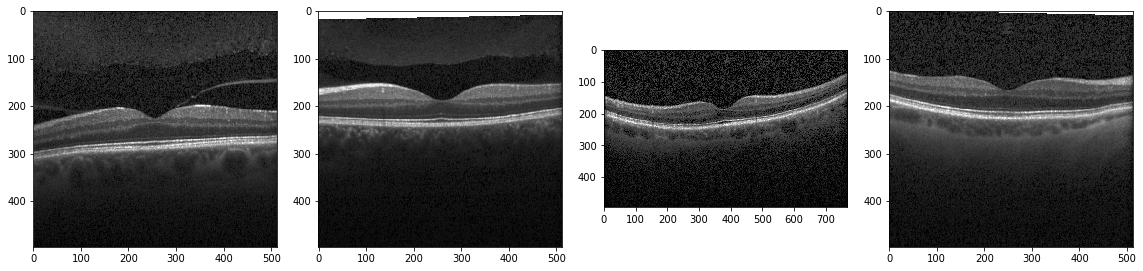

In [5]:
plot_imgs(test_normal_pth)

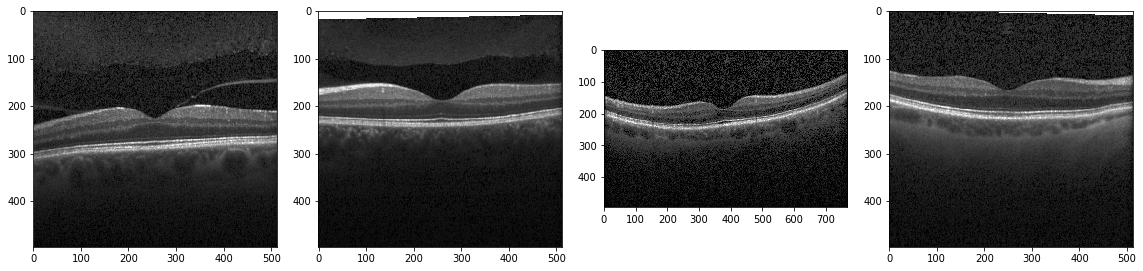

In [6]:
plot_imgs(test_normal_pth)

In [7]:
def Images_details_Print_data(data, path):
    print(" ====== Images in: ", path)    
    for k, v in data.items():
        print("%s:\t%s" % (k, v))

def Images_details(path):
    files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100  # No image will be bigger than that
    data['max_width'] = 0
    data['min_height'] = 10**100  # No image will be bigger than that
    data['max_height'] = 0


    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['min_height'] = min(height, data['min_height'])
        data['max_width'] = max(width, data['max_height'])
        
        data['max_height'] = max(height, data['max_height'])

    Images_details_Print_data(data, path)

In [8]:
Images_details(train_normal_pth)
Images_details(train_dme_pth)
Images_details(train_drusen_pth)
Images_details(train_cnv_pth)



 ====== Images in:  OCT2017/train\NORMAL
images_count:	26315
min_width:	384
max_width:	512
min_height:	496
max_height:	512
 ====== Images in:  OCT2017/train\DME
images_count:	11348
min_width:	512
max_width:	512
min_height:	496
max_height:	512
 ====== Images in:  OCT2017/train\DRUSEN
images_count:	8616
min_width:	512
max_width:	768
min_height:	496
max_height:	496
 ====== Images in:  OCT2017/train\CNV
images_count:	37205
min_width:	384
max_width:	1536
min_height:	496
max_height:	496


In [17]:
input_path = "OCT2017/"

for _set in ['train', 'test', 'val']:
    normal = len(os.listdir(input_path + _set + '/NORMAL'))
    dme = len(os.listdir(input_path + _set + '/DME'))
    drusen = len(os.listdir(input_path + _set + '/DRUSEN'))
    cnv = len(os.listdir(input_path + _set + '/CNV'))
    print('{}, Normal images: {}, DME images: {}, DRUSEN images: {}, CNV images: {}'.format(_set, normal, dme, drusen, cnv))

train, Normal images: 26315, DME images: 11348, DRUSEN images: 8616, CNV images: 37205
test, Normal images: 242, DME images: 242, DRUSEN images: 242, CNV images: 242
val, Normal images: 8, DME images: 8, DRUSEN images: 8, CNV images: 8


In [4]:
import imgaug as ia
import imgaug.augmenters as iaa

seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Invert(0.2),
        #iaa.Rotate((-45, 45)),
        #iaa.GaussianBlur(sigma=(0, 3.0)) 
        #iaa.Alpha((0.0, 1.0), iaa.AllChannelsHistogramEqualization())
        # blur images with a sigma of 0 to 3.0
    ])
def augment(img):
        seq_det = seq.to_deterministic()
        
        aug_image = seq_det.augment_image(img)
        return aug_image
    
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
      #  featurewise_center=True,
      #  featurewise_std_normalization=True,
        zoom_range = 0.3,
        horizontal_flip = True
        #preprocessing_function = augment 
    )
    
    test_datagen = ImageDataGenerator(
      #  featurewise_center=True,
      #  featurewise_std_normalization=True,
        rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory = train_path, 
    target_size = (img_dims, img_dims), 
    batch_size = batch_size, 
    class_mode = 'categorical', 
    shuffle=True)

    test_gen = test_datagen.flow_from_directory(
    directory=val_path, 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/DME/', '/DRUSEN/', '/CNV/']:
        for img in (os.listdir(val_path + cond)):
            img = plt.imread(val_path + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            #img = np.dstack([img, img, img])
            
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/DME/':
                label = 1
            elif cond=='/DRUSEN/':
                label = 2
            elif cond=='/CNV/':
                label = 3
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

error: OpenCV(4.2.0) d:\bld\libopencv_1579753492509\work\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x03f6a1c9::Set<1,-1,-1>,struct cv::impl::A0x03f6a1c9::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [7]:
PARAMS = {'img_dims': 160,
          'epochs': 35,
          'batch_size': 32,
          'optimizer': 'adam',
          'loss': 'categorical_crossentropy',
          'metrics': 'accuracy',
          }


In [8]:
#train_gen, test_gen, test_data, test_labels = process_data(PARAMS['img_dims'], PARAMS['batch_size'])


# Constant to control how often we print when training models
print_every = 100
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)
train_gen, test_gen, test_data, test_labels = process_data(PARAMS['img_dims'], PARAMS['batch_size'])
inputs = Input(shape=(PARAMS['img_dims'], PARAMS['img_dims'], 3))


Using device:  /device:GPU:0
Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [9]:
from sklearn.utils import class_weight

#train_gen, test_gen, test_data, test_labels = process_data(PARAMS['img_dims'], PARAMS['batch_size'])

#create class weights for unbalanced dataset
y_train = train_gen.classes
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(weights = "imagenet", include_top=False, input_shape=(PARAMS['img_dims'], PARAMS['img_dims'], 3))

# Freeze front layers
for layer in model.layers:
    layer.trainable = False

# Adding FC layers 
x = model.output
x = Flatten()(x)
# x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

model = Model(inputs=model.input, outputs=predictions)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [11]:
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [13]:
history = model.fit_generator(train_gen, epochs=PARAMS['epochs'],
                              steps_per_epoch=train_gen.samples // PARAMS['batch_size'],
                              validation_data=test_gen,
                              callbacks=[es],
                             class_weight=class_weights)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2608 steps, validate for 1 steps
Epoch 1/35
2608/2608 [==============================] - 732s 281ms/step - loss: 0.6629 - accuracy: 0.7673 - val_loss: 0.2886 - val_accuracy: 0.9062
Epoch 2/35
2608/2608 [==============================] - 724s 278ms/step - loss: 0.5398 - accuracy: 0.8131 - val_loss: 0.3305 - val_accuracy: 0.9375
Epoch 3/35
2608/2608 [==============================] - 725s 278ms/step - loss: 0.5087 - accuracy: 0.8265 - val_loss: 0.1963 - val_accuracy: 0.9375
Epoch 4/35
2608/2608 [==============================] - 724s 277ms/step - loss: 0.4866 - accuracy: 0.8351 - val_loss: 0.2266 - val_accuracy: 0.9375
Epoch 5/35
2608/2608 [==============================] - 725s 278ms/step - loss: 0.4746 - accuracy: 0.8397 - val_loss: 0.1768 - val_accuracy: 0.9062
Epoch 6/35
2608/2608 [==============================] - 725s 278ms/step - loss: 0.4594 - ac

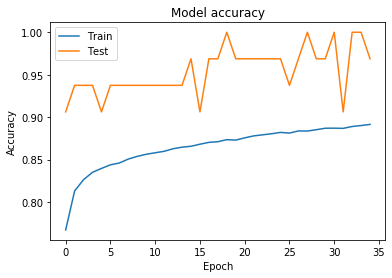

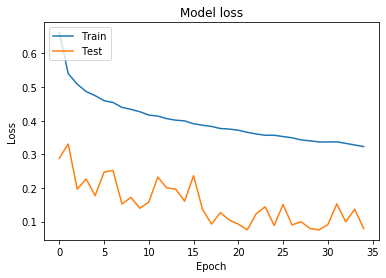

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
eval_test_datagen = ImageDataGenerator(
#  featurewise_center=True,
#  featurewise_std_normalization=True,
rescale=1./255)

# This is fed to the network in the specified batch sizes and image dimensions
eval_test_gen = eval_test_datagen.flow_from_directory(
directory = test_path, 
target_size = (160, 160), 
batch_size = 32,
class_mode = 'categorical', 
shuffle=True)
model.evaluate(eval_test_gen)

Found 968 images belonging to 4 classes.
  ...
    to  
  ['...']
31/31 [==============================] - 10s 330ms/step - loss: 0.0910 - accuracy: 0.9773


[0.09101805156998095, 0.97727275]

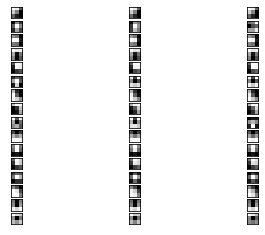

In [26]:
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
#f_min, f_max = filters.min(), filters.max()
#filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 16, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [27]:
model.save("transferlearning")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: transferlearning\assets
